In [137]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, data, filters, color, morphology
from skimage.segmentation import flood, flood_fill
from skimage.measure import label, regionprops
from skimage.morphology import remove_small_objects, skeletonize, area_closing, thin
from skimage.filters import threshold_otsu
from skimage.filters.rank import maximum
from skimage.morphology import binary_opening, binary_closing, binary_dilation
from skimage.morphology import disk

In [ ]:
def expand_wide_fractures_gt(img, gt, disk_size=2, thresh=30, gt_thresh=100, gt_ext='png'):
    """
    Expand the ground truth (gt) mask to include wide fractures in the image.
    This function uses a maximum filter to identify large areas of dark pixels in the image,
    and then dilates the gt mask to include these areas. The function also checks for spatial
    contiguity with the gt mask, and only keeps objects that are spatially contiguous with
    objects in the gt mask.

    Parameters
    -----------
    img (numpy.ndarray): The input image.
    gt (numpy.ndarray): The ground truth mask.
    disk_size (int): The size of the disk used for morphological operations.
    thresh (int): The threshold value for the maximum filter.
    gt_thresh (int): The threshold value for the ground truth mask.
    gt_ext (str): The file extension for the ground truth mask.

    Returns
    -----------
    numpy.ndarray: The expanded ground truth mask.
    """
    gray = img[...,1] # convert to greyscale (use green channel so vegetation is not so dark)
    imax = maximum( gray, disk(disk_size)) # use a maximum filter to only keep large areas of dark pixels
    #thresh = np.min(imax) * tmul # threshold based on the minimum remaining value in the image
    msk = binary_dilation( imax < thresh, disk(disk_size)) # dilate again after threshold to "re-fill" the dark areas
    
    # add in gt again
    gtg = np.logical_or( msk, gt > gt_thresh )
    
    # only keep objects that are spatially contiguous with objects in the gt
    labeled_components, num_components = label(gtg, connectivity=1, return_num=True)
    overlap_check = []
    for component_id in range(1, num_components + 1): # Check overlap with gt
        component_mask = labeled_components == component_id
        if not np.any(gt[component_mask] > gt_thresh):
            gtg[component_mask] = 0

    if 'tif' in gt_ext:
        new_gt = np.array(gt*255, dtype=np.uint8) | np.array(gtg*255, dtype=np.uint8)
    else:
        new_gt = np.array(gt, dtype=np.uint8) | np.array(gtg*255, dtype=np.uint8)
    return new_gt

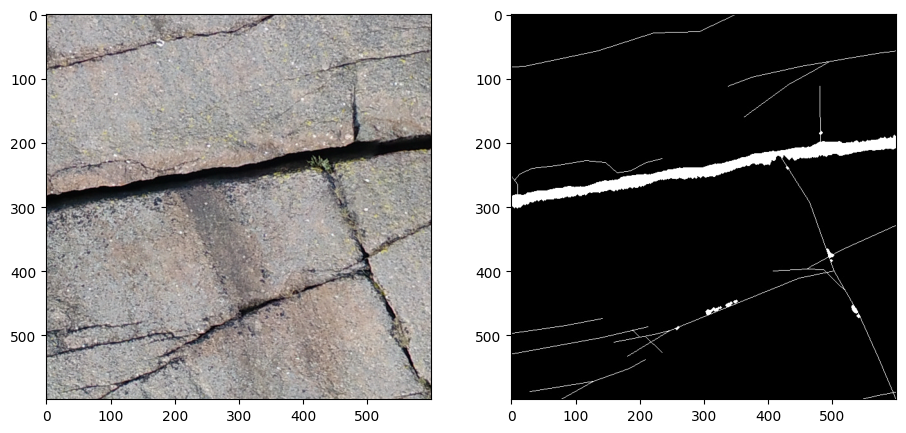

In [199]:
img = io.imread('data/kl5-s3.png')[400:1000, 400:1000, :3]
gt = io.imread('data/kl5-s3-gt.jpeg')[400:1000, 400:1000]

fig, axs = plt.subplots(1, 2, figsize=(11, 5))
axs[0].imshow(img)
gtg = expand_wide_fractures_gt(img, gt)
axs[1].imshow(gtg, cmap='gray', interpolation=None)

/Users/thiele67/miniforge3/envs/hylite/lib/python3.11/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: divide by zero encountered in matmul
  return rgb @ coeffs
/Users/thiele67/miniforge3/envs/hylite/lib/python3.11/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: overflow encountered in matmul
  return rgb @ coeffs
/Users/thiele67/miniforge3/envs/hylite/lib/python3.11/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: invalid value encountered in matmul
  return rgb @ coeffs


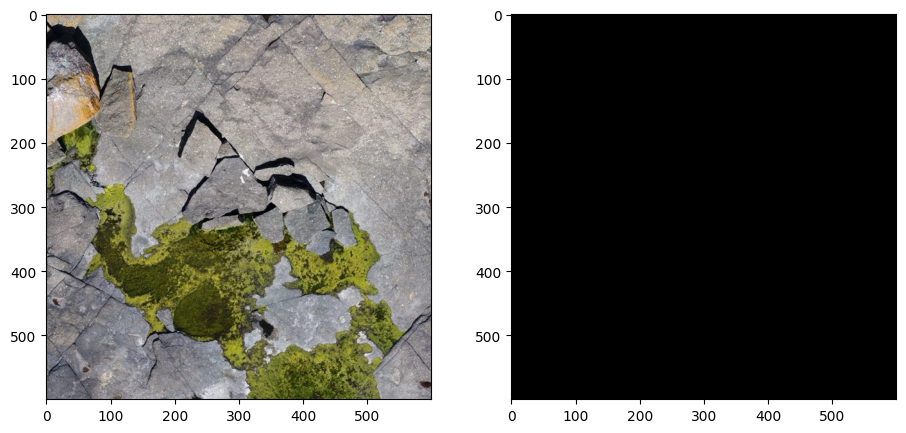

In [197]:
img = io.imread('data/OG1_sample_3 Large.jpeg')[400:1000, 400:1000, :3]
gt = io.imread('data/OG1_sample_3 Large.jpeg')[400:1000, 400:1000, 0]*0  ## best check this once some real labels are available...
gray = color.rgb2gray(img)

fig, axs = plt.subplots(1, 2, figsize=(11, 5))
axs[0].imshow(img)
gtg = expand_wide_fractures_gt(img, gt)
axs[1].imshow(gtg>0, cmap='gray', interpolation=None)

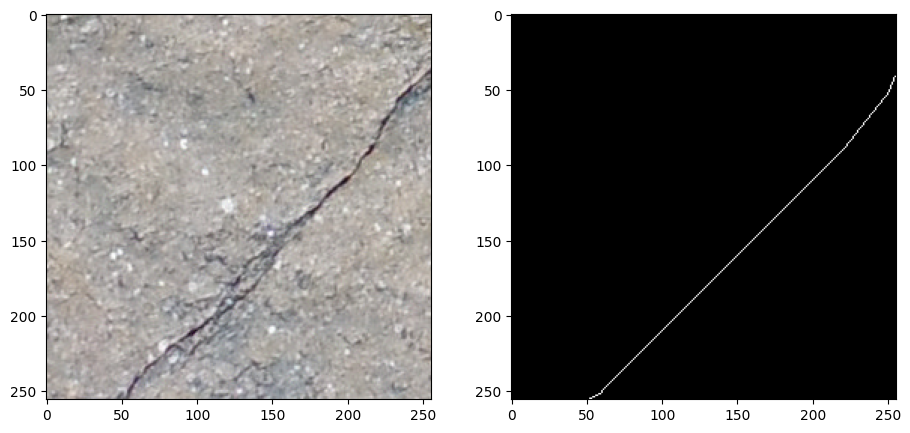

In [196]:
img = io.imread('data/OG1_23_74.png')[:, :, :3]
gt = io.imread('data/gtOG1_23_74.png')[:, :, 0]
gray = color.rgb2gray(img)

fig, axs = plt.subplots(1, 2, figsize=(11, 5))
axs[0].imshow(img)
gtg = expand_wide_fractures_gt(img, gt)
axs[1].imshow(gtg>0, cmap='gray', interpolation=None)

/Users/thiele67/miniforge3/envs/hylite/lib/python3.11/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: divide by zero encountered in matmul
  return rgb @ coeffs
/Users/thiele67/miniforge3/envs/hylite/lib/python3.11/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: overflow encountered in matmul
  return rgb @ coeffs
/Users/thiele67/miniforge3/envs/hylite/lib/python3.11/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: invalid value encountered in matmul
  return rgb @ coeffs


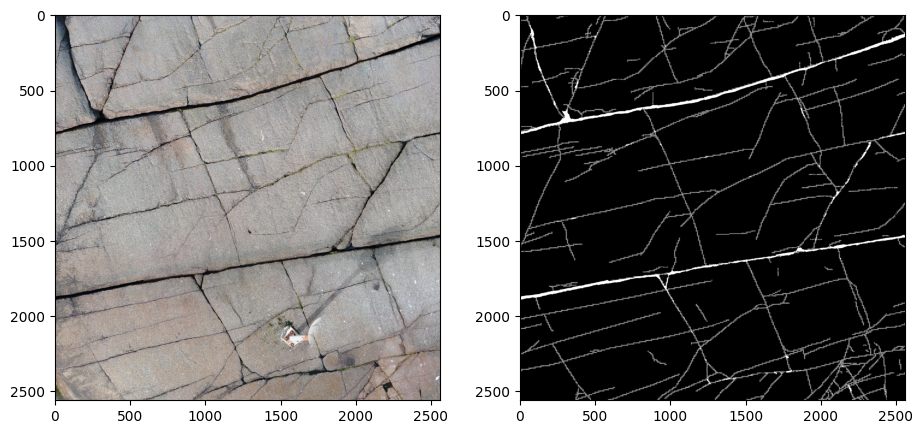

In [ ]:
img = io.imread('data/kl5-s3.png')[:, :, :3]
gt = io.imread('data/kl5-s3-gt.jpeg')[:, :] # N.B. Never save you GT as JPG! (As the compression changes the pixles). PNG is much better for this type of data
gray = color.rgb2gray(img)

fig, axs = plt.subplots(1, 2, figsize=(11, 5))
axs[0].imshow(img)
gtg = expand_wide_fractures_gt(img, gt)
axs[1].imshow(gtg>0, cmap='gray', interpolation=None)

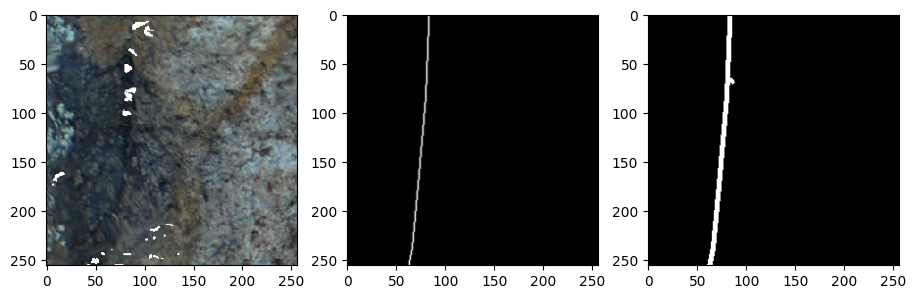

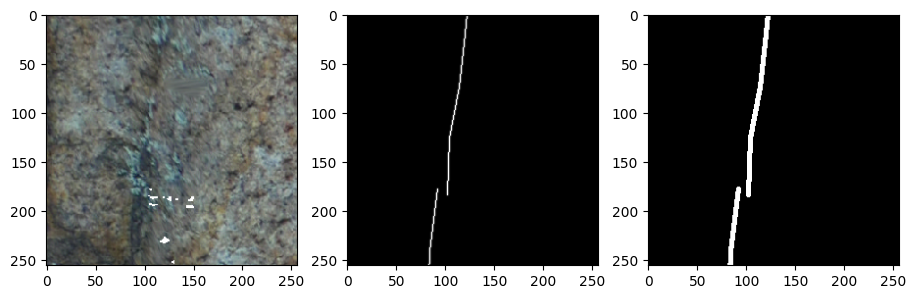

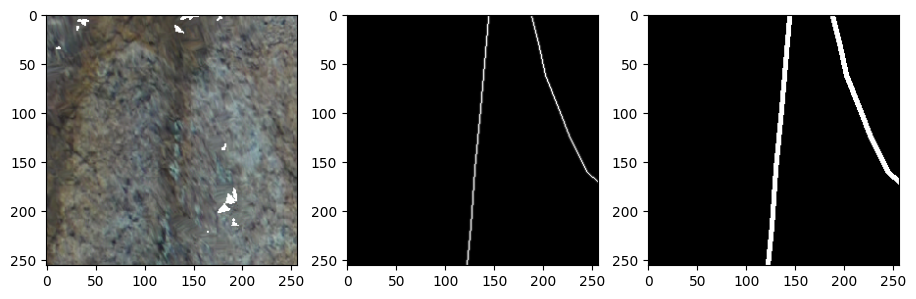

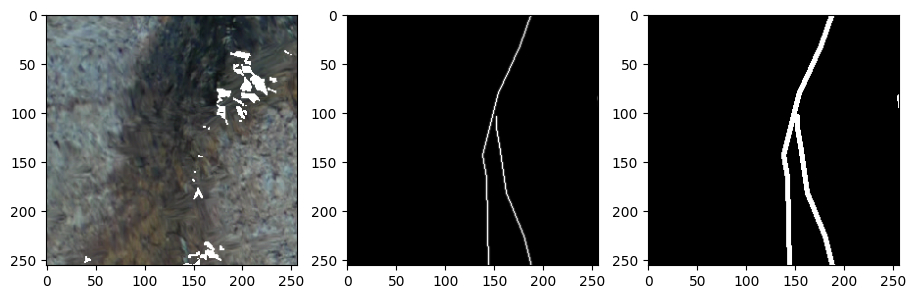

In [194]:
for i in range(126, 130):
    img = io.imread(f'data/train_matteo/image/Site_A_{i}.tif')[:, :, :3].astype(np.uint8)
    gt = (io.imread(f'data/train_matteo/gt/Site_A_{i}.tif')*255).astype(np.uint8)
    gray = color.rgb2gray(img)
    
    fig, axs = plt.subplots(1, 3, figsize=(11, 5))
    axs[0].imshow(img)
    axs[1].imshow(gt, cmap='gray')
    gtg = expand_wide_fractures_gt(img, gt)
    axs[2].imshow(gtg>0, cmap='gray', interpolation=None)

In [53]:
img.max(), img.min()

(255.0, 8.0)

In [25]:
from ipywidgets import widgets

def show(img, size=4):
    fig, ax = plt.subplots(1, 1, figsize=(size, size))
    ax.imshow(img, cmap=plt.cm.gray)
    ax.set_axis_off()
    plt.show()

@widgets.interact(x=(0, 1, .01))
def threshold(x):
    show(gray < x, size=7)

interactive(children=(FloatSlider(value=0.0, description='x', max=1.0, step=0.01), Output()), _dom_classes=('w…

In [92]:
gt_skeleton = gt
gray = color.rgb2gray(img)

# Prepare output mask (binary)
expanded_mask = np.zeros_like(gray, dtype=bool)

# Define intensity threshold for flood (e.g., allow flooding below this value)
flood_threshold = 50

# Get seed coordinates from skeleton
seed_points = np.argwhere(gt_skeleton)

# Flood from each seed point
for y, x in seed_points:
    flooded_region = flood(gray, (y, x))
    expanded_mask |= flooded_region  # accumulate flood results

expanded_mask += np.array(gt, dtype='bool')

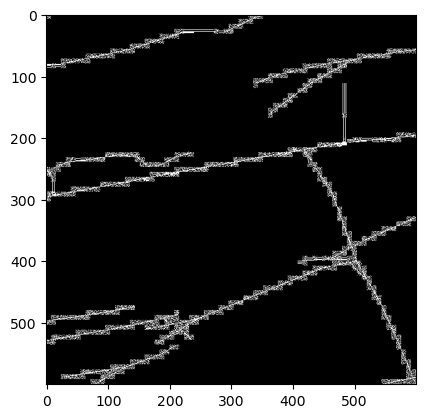

In [93]:
plt.imshow(expanded_mask, cmap='gray')

In [77]:
len(seed_points)

15947

In [78]:
expanded_mask.min(), expanded_mask.max()

(False, True)